# Logistic Regression

## Setup

In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

from src.data import DataLoaderScratch
from src.trainer import TrainerScratch
from src.optimizers import SGDScratch
from src.metrics import AccuracyScratch

## Preprocessing

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
mnist_trainset = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
mnist_testset = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

# Transform the training data
X_train = mnist_trainset.data[:1000, :, :].float() / 255.0
X_train = X_train.view(X_train.shape[0], -1)
y_train = mnist_trainset.targets[:1000]

# Transform the test data
X_val = mnist_testset.data[:100, :, :].float() / 255.0
X_val = X_val.view(X_val.shape[0], -1)
y_val = mnist_testset.targets[:100]

train_dataloader = DataLoaderScratch(X_train, y_train, batch_size=256, shuffle=True)
val_dataloader = DataLoaderScratch(X_val, y_val, batch_size=256, shuffle=False)

## Theoretical Background

## Multilayer Perceptron From Scratch

Our network will have 2 hidden layers.

- W1: X with shape (num_samples, in_features) will be transformed by W1 (in_features, num_units) to Z1 with shape (num_samples, num_units).
- b1: b1 will be added to the matrix product of X and W1 which will be size (num_samples, num_units), so we will make it shape (num_units).
- W2: A1 with shape (num_samples, num_units) will be transformed by W2 (num_units, num_outpurs) to Z2 with shape (num_samples, num_classes).
- b2: b2 will be added to the matrix product of A1 and W2 which will be size (num_samples, num_classes), so we will make it shape (num_classes).

### Single Batch Iteration

In [3]:
# Create a batch
batch_size = 128
perm = torch.randperm(len(X_train))
X_batch = X_train[perm][:batch_size]
y_batch = y_train[perm][:batch_size]

in_features = X_train.shape[1]
num_units = 256
num_classes = y_train.unique().shape[0]


def relu(x):
    out = torch.maximum(x, torch.zeros(1))
    return out


def softmax(X):
    X_exp = torch.exp(X)
    X_softmax = X_exp / X_exp.sum(axis=1, keepdims=True)
    return X_softmax


# Define the log-loss
def log_loss(y_pred, y):
    y_one_hot = nn.functional.one_hot(y)
    loss = -(y_one_hot * torch.log(y_pred)).sum(axis=1).mean()
    return loss


W1 = nn.Parameter(torch.randn(in_features, num_units) * 0.01)
b1 = nn.Parameter(torch.zeros(num_units))
W2 = nn.Parameter(torch.randn(num_units, num_classes) * 0.01)
b2 = nn.Parameter(torch.zeros(num_classes))

parameters = [W1, b1, W2, b2]
optimizer = SGDScratch(parameters, lr=0.5)

In [4]:
num_epochs = 3
for epoch in range(num_epochs):
    total_loss = 0
    for batch in train_dataloader:
        inputs, targets = batch
    
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        Z1 = X_batch @ W1 + b1
        A1 = relu(Z1)
        Z2 = A1 @ W2 + b2
        y_pred = softmax(Z2)
        
        # Calculate Loss
        loss = log_loss(y_pred, y_batch)
        
        # Backward pass (compute gradients)
        loss.backward()
        
        # Update parameters
        optimizer.step()
        total_loss += loss.item()

    print(total_loss / len(train_dataloader))

2.2754393219947815
2.125459313392639
1.7038659155368805


In [5]:
get_shape = lambda x: tuple([x.shape[i] for i in range(len(x.shape))])

print("X_batch:", get_shape(X_batch))
print("W1:", get_shape(W1))
print("b1:", get_shape(b1))
print("Z1:", get_shape(Z1))
print("A1:", get_shape(A1))
print("W2:", get_shape(W2))
print("b2:", get_shape(b2))
print("Z2:", get_shape(Z2))
print("y_pred:", get_shape(y_pred))

X_batch: (128, 784)
W1: (784, 256)
b1: (256,)
Z1: (128, 256)
A1: (128, 256)
W2: (256, 10)
b2: (10,)
Z2: (128, 10)
y_pred: (128, 10)


### Define Training Loop and Model

In [6]:
class MLPScratch(nn.Module):
    def __init__(self, in_features, num_classes, num_units):
        super().__init__()
        self.num_classes = num_classes
        self.W1 = nn.Parameter(torch.randn(in_features, num_units) * 0.01)
        self.b1 = nn.Parameter(torch.zeros(num_units))
        self.W2 = nn.Parameter(torch.randn(num_units, num_classes) * 0.01)
        self.b2 = nn.Parameter(torch.zeros(num_classes))

    def relu(self, X):
        out = torch.maximum(X, torch.zeros(1))
        return out

    def softmax(self, X):
        X_exp = torch.exp(X)
        X_softmax = X_exp / X_exp.sum(axis=1, keepdims=True)
        return X_softmax

    def forward(self, X):
        # Forward pass
        Z1 = X @ self.W1 + self.b1
        A1 = self.relu(Z1)
        Z2 = A1 @ self.W2 + self.b2
        y_pred = self.softmax(Z2)
        return y_pred

    def parameters(self):
        return [self.W1, self.b1, self.W2, self.b2]

In [7]:
class CrossEntropyScratch(nn.Module):
    def __init__(self, num_classes):
        super(CrossEntropyScratch, self).__init__()
        self.num_classes = num_classes

    def forward(self, y_pred, y_true):
        y_one_hot = nn.functional.one_hot(y_true, self.num_classes)
        loss = -(y_one_hot * torch.log(y_pred)).sum(axis=1).mean()
        return loss

### Define Training Loop and Model

Epoch 1/20, Training Loss: 2.2931, Validation Loss: 2.2735
Validation accuracy: 0.5000
Epoch 2/20, Training Loss: 2.2532, Validation Loss: 2.2173
Validation accuracy: 0.5200
Epoch 3/20, Training Loss: 2.1683, Validation Loss: 2.0936
Validation accuracy: 0.5800
Epoch 4/20, Training Loss: 1.9938, Validation Loss: 1.8654
Validation accuracy: 0.6300
Epoch 5/20, Training Loss: 1.7084, Validation Loss: 1.5291
Validation accuracy: 0.6700
Epoch 6/20, Training Loss: 1.3748, Validation Loss: 1.2417
Validation accuracy: 0.7000
Epoch 7/20, Training Loss: 1.1049, Validation Loss: 1.0539
Validation accuracy: 0.7400


Epoch 8/20, Training Loss: 0.9162, Validation Loss: 0.9249
Validation accuracy: 0.7500
Epoch 9/20, Training Loss: 0.7831, Validation Loss: 0.8431
Validation accuracy: 0.8000
Epoch 10/20, Training Loss: 0.6977, Validation Loss: 0.7409
Validation accuracy: 0.7900
Epoch 11/20, Training Loss: 0.6305, Validation Loss: 0.7142
Validation accuracy: 0.8200
Epoch 12/20, Training Loss: 0.5761, Validation Loss: 0.6931
Validation accuracy: 0.8000
Epoch 13/20, Training Loss: 0.5488, Validation Loss: 0.6207
Validation accuracy: 0.8200
Epoch 14/20, Training Loss: 0.4817, Validation Loss: 0.6456
Validation accuracy: 0.8000
Epoch 15/20, Training Loss: 0.4565, Validation Loss: 0.6089
Validation accuracy: 0.8000
Epoch 16/20, Training Loss: 0.4221, Validation Loss: 0.6073
Validation accuracy: 0.8000
Epoch 17/20, Training Loss: 0.4111, Validation Loss: 0.5686
Validation accuracy: 0.8400
Epoch 18/20, Training Loss: 0.3909, Validation Loss: 0.5359
Validation accuracy: 0.8300
Epoch 19/20, Training Loss: 0.3785

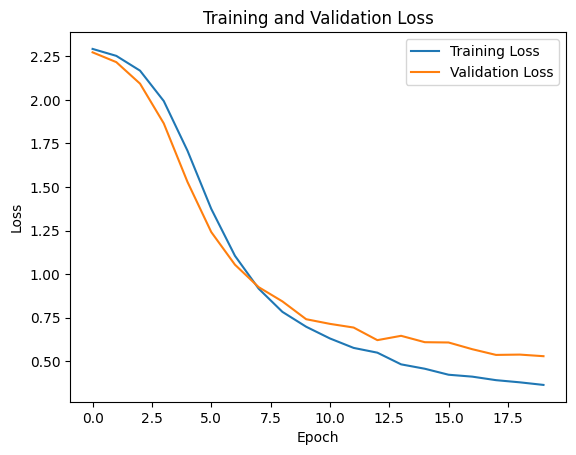

In [8]:
in_features = X_train.shape[1]
num_classes = y_train.unique().shape[0]
num_units = 256
num_epochs = 20
learning_rate = 0.3

model = MLPScratch(in_features, num_classes, num_units)
optimizer = SGDScratch(model.parameters(), lr=learning_rate)
criterion = CrossEntropyScratch(num_classes=num_classes)
metrics = {'accuracy': AccuracyScratch()}
trainer = TrainerScratch(model, train_dataloader, val_dataloader, optimizer, criterion, custom_metrics=metrics)
trainer.fit(num_epochs=num_epochs)

## Concise Implementation of MLP

Epoch 1/10, Training Loss: 2.2222, Validation Loss: 2.0810
Validation accuracy: 0.5700
Epoch 2/10, Training Loss: 1.9345, Validation Loss: 1.7402
Validation accuracy: 0.6700
Epoch 3/10, Training Loss: 1.5376, Validation Loss: 1.3848
Validation accuracy: 0.7000
Epoch 4/10, Training Loss: 1.1740, Validation Loss: 1.1359
Validation accuracy: 0.7400
Epoch 5/10, Training Loss: 0.9355, Validation Loss: 0.9448
Validation accuracy: 0.7300
Epoch 6/10, Training Loss: 0.7581, Validation Loss: 0.8674
Validation accuracy: 0.7300
Epoch 7/10, Training Loss: 0.6702, Validation Loss: 0.7604
Validation accuracy: 0.7400
Epoch 8/10, Training Loss: 0.6017, Validation Loss: 0.7408
Validation accuracy: 0.7500
Epoch 9/10, Training Loss: 0.5337, Validation Loss: 0.6330
Validation accuracy: 0.8100
Epoch 10/10, Training Loss: 0.4774, Validation Loss: 0.6094
Validation accuracy: 0.8000


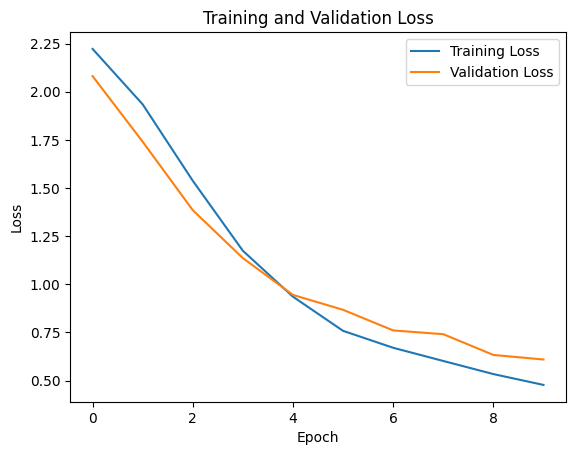

In [9]:
# Assuming X and y are your feature and target tensors
# Split Data into Train and Test Sets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# Define DataLoader
batch_size = 256
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

class MLP(nn.Module):
    def __init__(self, in_features, num_classes, num_units):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_features, num_units)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(num_units, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

in_features = X_train.shape[1]
num_classes = y_train.unique().shape[0]
num_units = 256
model = MLP(in_features, num_classes, num_units)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.3)
metrics = {'accuracy': AccuracyScratch()}
trainer = TrainerScratch(model, train_dataloader, val_dataloader, optimizer, criterion, custom_metrics=metrics)
trainer.fit(num_epochs=10)